
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Юрий Исаков и Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>  Практика. Идентификация пользователя с помощью логистической регрессии

Тут мы воспроизведем парочку бенчмарков нашего соревнования и вдохновимся побить третий бенчмарк, а также остальных участников. Веб-формы для отправки ответов тут не будет, ориентир – [leaderboard](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard) соревнования.

In [803]:
import pickle

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold, TimeSeriesSplit, GridSearchCV


import warnings
warnings.filterwarnings('ignore')

from IPython.display import display_html
import eli5


%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

### 1. Загрузка и преобразование данных
Зарегистрируйтесь на [Kaggle](www.kaggle.com), если вы не сделали этого раньше, зайдите на [страницу](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования и скачайте данные. Первым делом загрузим обучающую и тестовую выборки и посмотрим на данные.

In [2]:
times = ["time%s" % i for i in range(1, 11)]
train_df = pd.read_csv("data/train_sessions.csv", index_col="session_id", parse_dates=times)
test_df = pd.read_csv("data/test_sessions.csv", index_col="session_id", parse_dates=times)

# отсортируем данные по времени
train_df = train_df.sort_values(by="time1")

# посмотрим на заголовок обучающей выборки
train_df.head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


В обучающей выборке содержатся следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - target – целевая переменная, 1 для сессий Элис, 0 для сессий других пользователей
    
Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд либо когда сессия заняла по времени более 30 минут.

В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулями и приведем признаки к целому типу. Также загрузим словарь сайтов и посмотрим, как он выглядит:

In [3]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ["site%s" % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype("int")
test_df[sites] = test_df[sites].fillna(0).astype("int")

# загрузим словарик сайтов
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(
    list(site_dict.keys()), index=list(site_dict.values()), columns=["site"]
)
print(u"всего сайтов:", sites_dict_df.shape[0])
sites_dict_df.head()

всего сайтов: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


### EDA

In [4]:
# The most popular sites
top_sites = pd.Series(train_df[sites].values.flatten()) \
                     .value_counts().sort_values(ascending=False).head(10)
sites_dict_df.loc[top_sites.drop(0).index]

,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com
167,www.bing.com
780,blast.ncbi.nlm.nih.gov
778,www.ncbi.nlm.nih.gov
52,clients1.google.com


#### The most popular sites for Alice

In [5]:
top_sites_Alice = pd.Series(train_df.loc[train_df.target==1, sites].values.flatten()) \
                     .value_counts().sort_values(ascending=False).head(10)
sites_dict_df.loc[top_sites_Alice.index]

,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


#### Looking timestapms

In [6]:
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)
time_df['seconds'] = (time_df['max'] - time_df['min']).dt.seconds
time_df

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2
...,...,...,...,...
12224,0,2014-04-30 23:33:48,2014-04-30 23:34:00,12
164438,0,2014-04-30 23:34:15,2014-04-30 23:37:13,178
12221,0,2014-04-30 23:38:08,2014-04-30 23:38:36,28


In [7]:
time_df['target'].value_counts(normalize=True) * 100

0    99.094104
1     0.905896
Name: target, dtype: float64

In [8]:
def approximately_same(x, y):
    return abs(x-y) / max(x, y) <= 0.05

In [9]:
# Alice session mean
alice_mean = time_df[time_df['target'] == 1]['seconds'].mean()
not_alice_mean = time_df[time_df['target'] == 0]['seconds'].mean()
print(f'Alice mean session: {alice_mean}')
print(f'Not Alice mean session: {not_alice_mean}')

# Max time session is appoximately the same
max_Alice_session = time_df[time_df['target'] == 1]['seconds'].max()
max_not_Alice_session = time_df[time_df['target'] == 0]['seconds'].max()
print(f'Alice max ~ others max: {approximately_same(max_Alice_session, max_not_Alice_session)}')

alice_std = time_df[time_df['target'] == 1]['seconds'].std()
not_alice_std = time_df[time_df['target'] == 0]['seconds'].std()
approximately_same(alice_std, not_alice_std)
print(f'Alice std ~ others std: {approximately_same(alice_std, not_alice_std)}')

Alice mean session: 52.29647366129734
Not Alice mean session: 139.28237232552215
Alice max ~ others max: True
Alice std ~ others std: False


0.2411841532433609

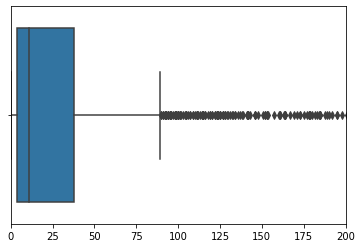

In [10]:
sns.boxplot(time_df[time_df['target'] == 1]['seconds'].values)
plt.xlim([0, 200])
(time_df[time_df['target'] == 1]['seconds'] >= 40).sum() / time_df[time_df['target'] == 1].shape[0]

In [136]:
time_df.groupby('target')['seconds'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,251264.0,139.282372,296.653518,0.0,7.0,28.0,114.0,1800.0
1,2297.0,52.296474,153.309014,0.0,4.0,11.0,38.0,1763.0


In [189]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat["start_month"] = (
    full_df["time1"].apply(lambda ts: 100 * ts.year + ts.month).astype("float64")
)

start_month
201301.0      0
201302.0     61
201303.0      0
201304.0     38
201305.0      0
201306.0      0
201307.0      0
201308.0      0
201309.0    377
201310.0      0
201311.0    446
201312.0    134
201401.0    129
201402.0    410
201403.0    400
201404.0    302
Name: target, dtype: int64


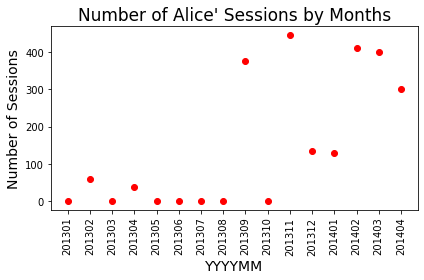

In [190]:
# Answer

# Compute number of Alice's sessions by months
tmp = full_new_feat.loc[:idx_split, "start_month"].to_frame()
tmp["target"] = y_train
stm_vs_target = tmp.groupby("start_month")["target"].sum()

# Print the table
print(stm_vs_target)

# Plot the graph
x_axis = stm_vs_target.index.astype("int").astype("str")
y_axis = stm_vs_target.values
plt.plot(x_axis, y_axis, "ro")
plt.xticks(x_axis, x_axis, rotation="vertical")
plt.xlabel("YYYYMM", fontsize=14)
plt.ylabel("Number of Sessions", fontsize=14)
plt.title(u"Number of Alice' Sessions by Months", y=1.0, fontsize=17)
plt.tight_layout();

### Prepare Data

Выделим целевую переменную и объединим выборки, чтобы вместе привести их к разреженному формату.

In [137]:
# наша целевая переменная
y_train = train_df["target"]

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

Для самой первой модели будем использовать только посещенные сайты в сессии (но не будем обращать внимание на временные признаки). За таким выбором данных для модели стоит такая идея:  *у Элис есть свои излюбленные сайты, и чем чаще вы видим эти сайты в сессии, тем выше вероятность, что это сессия Элис и наоборот.*

Подготовим данные, из всей таблицы выберем только признаки `site1, site2, ... , site10`. Напомним, что пропущенные значения заменены нулем. Вот как выглядят первые строки таблицы:

In [138]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [18]:
full_sites.values.flatten()

array([  56,   55,    0, ..., 1098, 1098, 1098])

Сессии представляют собой последовательность индексов сайтов и данные в таком виде неудобны для линейных методов. В соответствии с нашей гипотезой (у Элис есть излюбленные сайты) надо преобразовать эту таблицу таким образом, чтобы каждому возможному сайту соответствовал свой отдельный признак (колонка), а его значение равнялось бы количеству посещений этого сайта в сессии. Это делается в две строчки:

In [141]:
from scipy.sparse import csr_matrix

In [142]:
csr_matrix?

In [143]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(
    (
        [1] * sites_flatten.shape[0],
        sites_flatten,
        range(0, sites_flatten.shape[0] + 10, 10),
    )
)[:, 1:]
full_sites_sparse.shape

(336358, 48371)

In [35]:
X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

In [36]:
X_train_sparse.shape, y_train.shape

((253561, 48371), (253561,))

Еще один плюс использования разреженных матриц в том, что для них имеются специальные реализации как матричных операций, так и алгоритмов машинного обучения, что подчас позволяет ощутимо ускорить операции за счет особенностей структуры данных. Это касается и логистической регрессии. Вот теперь у нас все готово для построения нашей первой модели.

### 2. Построение первой модели

Итак, у нас есть алгоритм и данные для него, построим нашу первую модель, воспользовавшись релизацией [логистической регрессии](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из пакета `sklearn` с параметрами по умолчанию. Первые 90% данных будем использовать для обучения (обучающая выборка отсортирована по времени), а оставшиеся 10% для проверки качества (validation). 

**Напишите простую функцию, которая будет возвращать качество модели на отложенной выборке, и обучите наш первый классификатор**.

In [43]:
def get_auc_lr_valid(X, y, C=1.0, ratio=0.9, seed=17):
    """
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    """

    train_len = int(X.shape[0] * ratio)
    X_train = X[:train_len]
    y_train = y[:train_len]
    X_valid = X[train_len:]
    y_valid = y[train_len:]
    
    logit = LogisticRegression(C=C, random_state=seed, n_jobs=-1)
    logit.fit(X_train, y_train)
    pred_valid = logit.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, pred_valid)

**Посмотрите, какой получился ROC AUC на отложенной выборке.**

In [44]:
%%time
get_auc_lr_valid(X_train_sparse, y_train)

CPU times: user 100 ms, sys: 44.4 ms, total: 145 ms
Wall time: 2.5 s


0.9197952555886044

Будем считать эту модель нашей первой отправной точкой (baseline). Для построения модели для прогноза на тестовой выборке **необходимо обучить модель заново уже на всей обучающей выборке** (пока наша модель обучалась лишь на части данных), что повысит ее обобщающую способность:

In [141]:
# функция для записи прогнозов в файл
def write_to_submission_file(
    predicted_labels, out_file, target="target", index_label="session_id"
):
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(1, predicted_labels.shape[0] + 1),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

**Обучите модель на всей выборке, сделайте прогноз для тестовой выборки и сделайте посылку в соревновании**.

In [48]:
logit = LogisticRegression(C=1, random_state=17, n_jobs=-1)
logit.fit(X_train_sparse, y_train)
test_pred = logit.predict_proba(X_test_sparse)[:, 1]

In [146]:
write_to_submission_file(test_pred, 'logit.csv')

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Если вы выполните эти действия и загрузите ответ на [странице](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования, то воспроизведете первый бенчмарк "Logit".

### 3. Улучшение модели, построение новых признаков

Создайте такой признак, который будет представлять собой число вида ГГГГММ от той даты, когда проходила сессия, например 201407 -- 2014 год и 7 месяц. Таким образом, мы будем учитывать помесячный [линейный тренд](http://people.duke.edu/~rnau/411trend.htm) за весь период предоставленных данных.

In [57]:
new_feat_train = pd.DataFrame(index=train_df.index)
new_feat_test = pd.DataFrame(index=test_df.index)

In [59]:
new_feat_train['year_month'] = train_df['time1'].apply(lambda x: int(x.year * 100 + x.month))
new_feat_test['year_month'] = test_df['time1'].apply(lambda x: int(x.year * 100 + x.month))

Добавьте новый признак, предварительно отмасштабировав его с помощью `StandardScaler`, и снова посчитайте ROC AUC на отложенной выборке.

In [63]:
scaler = StandardScaler()
scaler.fit(new_feat_train.values.reshape(-1, 1))

new_feat_train['year_month_scaled'] = scaler.transform(new_feat_train['year_month'].values.reshape(-1, 1))
new_feat_test['year_month_scaled'] = scaler.transform(new_feat_test['year_month'].values.reshape(-1, 1))

In [65]:
new_feat_train.head()

,year_month,year_month_scaled
session_id,,
21669,201301,-1.744405
54843,201301,-1.744405
77292,201301,-1.744405
114021,201301,-1.744405
146670,201301,-1.744405


In [67]:
X_train_sparse_new = csr_matrix(hstack([X_train_sparse, new_feat_train['year_month_scaled'].values.reshape(-1, 1)]))

In [78]:
X_test_sparse_new = csr_matrix(hstack([X_test_sparse, new_feat_test['year_month_scaled'].values.reshape(-1, 1)]))

In [145]:
%%time
get_auc_lr_valid(X_train_sparse_new, y_train)

CPU times: user 65.9 ms, sys: 79 ms, total: 145 ms
Wall time: 5.06 s


0.9198902054055882

**Добавьте два новых признака: start_hour и morning.**

Признак `start_hour` – это час в который началась сессия (от 0 до 23), а бинарный признак `morning` равен 1, если сессия началась утром и 0, если сессия началась позже (будем считать, что утро это если `start_hour равен` 11 или меньше).

**Посчитйте ROC AUC на отложенной выборке для выборки с:**
- сайтами, `start_month` и `start_hour`
- сайтами, `start_month` и `morning`
- сайтами, `start_month`, `start_hour` и `morning`

In [95]:
new_feat_train['start_hour'] = train_df['time1'].apply(lambda x: x.hour)
new_feat_test['start_hour'] = test_df['time1'].apply(lambda x: x.hour)

new_feat_train['is_morning'] = (new_feat_train['start_hour'] <= 11).astype('int')
new_feat_test['is_morning'] = (new_feat_test['start_hour'] <= 11).astype('int')

new_feat_train['start_month'] = train_df['time1'].apply(lambda x: x.month)
new_feat_test['start_month'] = test_df['time1'].apply(lambda x: x.month)

In [96]:
scaler = StandardScaler()
scaler.fit(new_feat_train[['start_hour', 'is_morning', 'start_month']])

new_feat_train[['start_hour_scaled', 'is_morning_scaled', 'start_month_scaled']] = scaler.transform(new_feat_train[['start_hour', 'is_morning', 'start_month']])
new_feat_test[['start_hour_scaled', 'is_morning_scaled', 'start_month_scaled']] = scaler.transform(new_feat_test[['start_hour', 'is_morning', 'start_month']])

In [101]:
# start_month и start_hour
X_train_sparse_check =  csr_matrix(hstack([X_train_sparse_new, new_feat_train[['start_hour_scaled', 'start_month_scaled']]]))
get_auc_lr_valid(X_train_sparse_check, y_train)

0.957577282207159

In [102]:
# start_month и morning
X_train_sparse_check =  csr_matrix(hstack([X_train_sparse_new, new_feat_train[['is_morning_scaled', 'start_month_scaled']]]))
get_auc_lr_valid(X_train_sparse_check, y_train)

0.9480045594026585

In [103]:
# start_hour и morning
X_train_sparse_check =  csr_matrix(hstack([X_train_sparse_new, new_feat_train[['is_morning_scaled', 'start_hour_scaled']]]))
get_auc_lr_valid(X_train_sparse_check, y_train)

0.9586546380796769

In [104]:
X_train_sparse_featured = csr_matrix(hstack([X_train_sparse_new, new_feat_train[['start_hour_scaled', 'is_morning_scaled', 'start_month_scaled']]]))
X_test_sparse_featured = csr_matrix(hstack([X_test_sparse_new, new_feat_test[['start_hour_scaled', 'is_morning_scaled', 'start_month_scaled']]]))

In [105]:
%%time
get_auc_lr_valid(X_train_sparse_featured, y_train)

CPU times: user 56.8 ms, sys: 38.3 ms, total: 95.1 ms
Wall time: 2.81 s


0.9586360707863716

In [86]:
logit = LogisticRegression(C=1, random_state=17, n_jobs=-1)
logit.fit(X_train_sparse_featured, y_train)
test_pred = logit.predict_proba(X_test_sparse_featured)[:, 1]

In [87]:
write_to_submission_file(test_pred, 'logit_with_features.csv')

### 4. Подбор коэффицициента регуляризации

Итак, мы ввели признаки, которые улучшают качество нашей модели по сравнению с первым бейслайном. Можем ли мы добиться большего значения метрики? После того, как мы сформировали обучающую и тестовую выборки, почти всегда имеет смысл подобрать оптимальные гиперпараметры -- характеристики модели, которые не изменяются во время обучения. Например, на 3 неделе вы проходили решающие деревья, глубина дерева это гиперпараметр, а признак, по которому происходит ветвление и его значение -- нет. В используемой нами логистической регрессии веса каждого признака изменяются и во время обучения находится их оптимальные значения, а коэффициент регуляризации остается постоянным. Это тот гиперпараметр, который мы сейчас будем оптимизировать.

Посчитайте качество на отложенной выборке с коэффициентом регуляризации, который по умолчанию `C=1`:

In [88]:
get_auc_lr_valid(X_train_sparse_featured, y_train, C=1)

0.9586546380796769

Постараемся побить этот результат за счет оптимизации коэффициента регуляризации. Возьмем набор возможных значений C и для каждого из них посчитаем значение метрики на отложенной выборке.

Найдите `C` из `np.logspace(-3, 1, 10)`, при котором ROC AUC на отложенной выборке максимален. 

In [89]:
C_values = np.logspace(-3, 1, 10)
C_vals = dict()
for c in C_values:
    score = get_auc_lr_valid(X_train_sparse_featured, y_train, C=c)
    C_vals[c] = score

In [90]:
max(C_vals.items(), key = lambda k : k[1])

(0.1668100537200059, 0.9607205891054973)

Наконец, обучите модель с найденным оптимальным значением коэффициента регуляризации и с построенными признаками `start_hour`, `start_month` и `morning`. Если вы все сделали правильно и загрузите это решение, то повторите второй бенчмарк соревнования.

In [106]:
logit = LogisticRegression(C=0.17, random_state=17, n_jobs=-1)
logit.fit(X_train_sparse_featured, y_train)
test_pred = logit.predict_proba(X_test_sparse_featured)[:, 1]

In [144]:
write_to_submission_file(test_pred, 'logit_with_features_regularized.csv')

### Другой подход Count Vectorizer

In [43]:
train_df[sites].to_csv('train_sites.txt', sep=' ', index=None, header=None)
test_df[sites].to_csv('test_sites.txt', sep=' ', index=None, header=None)
y = train_df['target']

In [392]:
vectorizer = CountVectorizer()
with open('train_sites.txt') as train_txt:
    train = vectorizer.fit_transform(train_txt)
with open('test_sites.txt') as test_txt:
    test = vectorizer.transform(test_txt)

In [46]:
logit = LogisticRegression(random_state=19)
scores = cross_val_score(logit, train, y, cv=5, scoring='roc_auc', n_jobs=-1)

In [47]:
print(scores.mean())
scores

0.8859549190229193


array([0.91412172, 0.83253933, 0.87702207, 0.89228333, 0.91380815])

### Adding 4 good features

In [148]:
def add_features(time1_Series, X, scaler, is_train=True):
    hour = time1_Series.apply(lambda x: x.hour)
    is_morning = ((hour >=7) & (hour <= 11)).astype(int)
    is_day = ((hour >=12) & (hour <= 18)).astype(int)
    is_evening = ((hour >=19) & (hour <= 23)).astype(int)
    is_night = ((hour >= 0) & (hour <=6)).astype(int)
    features = pd.DataFrame({'is_morning': is_morning, 'is_day': is_day, 'is_evening': is_evening, 'is_night': is_night})
    if is_train:
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
    return hstack([X, features])

In [149]:
scaler = StandardScaler()
train_features_4 = add_features(train_df['time1'], train, scaler=scaler)
test_features_4 = add_features(test_df['time1'], test, scaler=scaler, is_train=False)

In [150]:
logit = LogisticRegression(random_state=19)
scores = cross_val_score(logit, train_features_4, y, cv=5, scoring='roc_auc', n_jobs=-1)

In [151]:
print(scores.mean())
scores

0.9311469193976434


array([0.92492484, 0.90717193, 0.93226761, 0.94376193, 0.94760829])

### Add regularization

In [154]:
%%time
c_vals = np.logspace(-2, 2, 40)
skv = StratifiedKFold(n_splits=10, shuffle=True, random_state=19)
logit_cv = LogisticRegressionCV(Cs=c_vals, n_jobs=-1, random_state=19, cv=skv, scoring='roc_auc')
logit_cv.fit(train_features_4, y)

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

CPU times: user 6.9 s, sys: 1.58 s, total: 8.48 s
Wall time: 5min 13s


/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.26638017e-02, 1.60371874e-02, 2.03091762e-02,
       2.57191381e-02, 3.25702066e-02, 4.12462638e-02, 5.22334507e-02,
       6.61474064e-02, 8.37677640e-02, 1.06081836e-01, 1.34339933e-01,
       1.70125428e-01, 2.15443469e-01, 2.72833338e-01, 3.45510729e-01,
       4.37547938e-01, 5.54102033e-01, 7.01703829e-01, 8.88623816e-01,
       1.12533558e+00, 1.42...00,
       2.89426612e+00, 3.66524124e+00, 4.64158883e+00, 5.87801607e+00,
       7.44380301e+00, 9.42668455e+00, 1.19377664e+01, 1.51177507e+01,
       1.91448198e+01, 2.42446202e+01, 3.07029063e+01, 3.88815518e+01,
       4.92388263e+01, 6.23550734e+01, 7.89652287e+01, 1.00000000e+02]),
                     cv=StratifiedKFold(n_splits=10, random_state=19, shuffle=True),
                     n_jobs=-1, random_state=19, scoring='roc_auc')

In [156]:
best_c = logit_cv.C_

### Fit on all data

In [158]:
best_logit = LogisticRegression(random_state=19, C=best_c[0])
best_logit.fit(train_features_4, y)
pred = best_logit.predict_proba(test_features_4)[:, 1]
write_to_submission_file(pred, 'with_reg.csv')

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Now real competition

In [26]:
times = ["time%s" % i for i in range(1, 11)]
sites = ['site%d' % i for i in range(1, 11)]
train_df = pd.read_csv("data/train_sessions.csv", index_col="session_id", parse_dates=times)
test_df = pd.read_csv("data/test_sessions.csv", index_col="session_id", parse_dates=times)

train_df = train_df.sort_values(by="time1")
train_df.head(2)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


In [410]:
train = train_df.copy()
test = test_df.copy()

train[sites] = train[sites].fillna(0)
test[sites] = test[sites].fillna(0)

train = train[sites]
test = test[sites]

In [ ]:
train.to_csv('train_text.txt', header=None, index=None)
test.to_csv('test_text.txt', header=None, index=None)

In [548]:
def get_train_test(ngram=(1,5), max_features=None):
    tf_idf = TfidfVectorizer(ngram_range=ngram, max_features=max_features)
    with open('train_text.txt') as file:
        train = tf_idf.fit_transform(file)

    with open('test_text.txt') as file:
        test = tf_idf.transform(file)
    return train, test

print(train.shape)
print(test.shape)

(253561, 50000)
(82797, 50000)


In [412]:
train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,50,2014-04-30 23:33:48,50.0,2014-04-30 23:33:49,48.0,2014-04-30 23:33:52,49.0,2014-04-30 23:33:52,48.0,2014-04-30 23:33:53,...,2014-04-30 23:33:53,52.0,2014-04-30 23:33:54,49.0,2014-04-30 23:33:54,303.0,2014-04-30 23:33:57,304.0,2014-04-30 23:34:00,0
164438,4207,2014-04-30 23:34:15,753.0,2014-04-30 23:34:16,753.0,2014-04-30 23:34:17,52.0,2014-04-30 23:34:18,50.0,2014-04-30 23:34:18,...,2014-04-30 23:35:16,3346.0,2014-04-30 23:35:29,3359.0,2014-04-30 23:36:12,3346.0,2014-04-30 23:36:42,38.0,2014-04-30 23:37:13,0
12221,52,2014-04-30 23:38:08,3346.0,2014-04-30 23:38:10,784.0,2014-04-30 23:38:13,784.0,2014-04-30 23:38:18,3346.0,2014-04-30 23:38:22,...,2014-04-30 23:38:24,3324.0,2014-04-30 23:38:35,7330.0,2014-04-30 23:38:35,3594.0,2014-04-30 23:38:35,3329.0,2014-04-30 23:38:36,0


In [943]:
def generate_basic_features(start_time):
    df = pd.DataFrame(index=start_time.index)
    df['start_hour'] = start_time.apply(lambda x: x.hour)
    
    df['is_morning'] = ((df['start_hour'] >= 7) & (df['start_hour'] <= 11)).astype('int')
    df['is_day'] = ((df['start_hour'] >= 12) & (df['start_hour'] <= 18)).astype('int')
    df['is_evening'] = ((df['start_hour'] >= 19) & (df['start_hour'] <= 23)).astype('int')
    df['is_night'] = ((df['start_hour'] >= 0) & (df['start_hour'] <= 6)).astype('int')
    
    df['start_hour'] = df['start_hour'] / 24.0
    df['start_sin'] = np.sin(df['start_hour'] * 2 * np.pi / 24)
    df['start_cos'] = np.cos(df['start_hour'] * 2 * np.pi / 24)
    return df

In [186]:
train_feat = generate_basic_features(train_df.time1)
test_feat = generate_basic_features(test_df.time1)

In [827]:
train_time = pd.DataFrame(index=train_df.index)
test_time = pd.DataFrame(index=test_df.index)

def make_time_feat(df, train=True):
    df = df.copy()
    time_df = pd.DataFrame(index=df.index)
    if train:
        time_df['target'] = df['target']
    time_df['min'] = df[times].min(axis=1)
    time_df['max'] = df[times].max(axis=1)
    time_df['seconds'] = (time_df['max'] - time_df['min']).dt.seconds
    return time_df

In [188]:
train_time = make_time_feat(train_df, train=True)
test_time = make_time_feat(test_df, train=False)


,min,max,seconds
session_id,,,
1,2014-10-04 11:19:53,2014-10-04 11:20:00,7
2,2014-07-03 11:00:28,2014-07-03 11:01:53,85
3,2014-12-05 15:55:12,2014-12-05 15:56:36,84
4,2014-11-04 10:03:19,2014-11-04 10:03:23,4
5,2014-05-16 15:05:31,2014-05-16 15:05:44,13
...,...,...,...
82793,2014-10-02 18:20:09,2014-10-02 18:20:09,0
82794,2014-05-26 14:16:40,2014-05-26 14:17:19,39
82795,2014-05-02 11:21:56,2014-05-02 11:22:04,8


In [822]:
def sites_visited(df):
    df = df.copy()
    sites_visited = 10 - df[times].isna().sum(axis=1)
    visit = pd.DataFrame(index=df.index)
    visit['sites_visited'] = sites_visited
    return visit

In [823]:
train_visited = sites_visited(train_df)
test_visited = sites_visited(test_df)

In [117]:
print(train_time[train_time['target']==1].seconds.mean())
print(train_time[train_time['target']==0].seconds.mean())

52.29647366129734
139.28237232552215


<AxesSubplot:xlabel='seconds'>

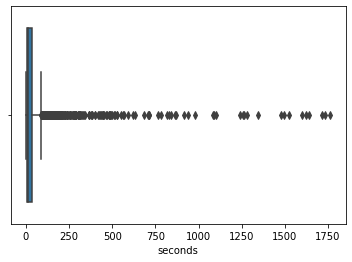

In [112]:
sns.boxplot(train_time[train_time['target']==1].seconds)

In [204]:
train_feat.shape, train_time.shape, train_visited.shape

((253561, 7), (253561, 4), (253561, 1))

In [555]:
train_together = pd.concat([train_feat, train_time, train_visited], axis=1)
test_together = pd.concat([test_feat, test_time, test_visited], axis=1)

In [824]:
def mean_site_time(df):
    df = df.copy()
    df['mean_site'] = df['seconds'] / df['sites_visited']
    return df

In [557]:
train_together = mean_site_time(train_together)
test_together = mean_site_time(test_together)

In [215]:
train_together.groupby('target')['mean_site'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,251264.0,16.803953,45.149464,0.0,0.7,2.8,11.9,900.00
1,2297.0,5.630960,19.005033,0.0,0.4,1.1,3.8,405.25


In [242]:
def best_Alice_sites(n=20):
    return pd.Series(train_df.loc[train_df.target==1, :][sites]\
                     .values.flatten()).value_counts()\
                     .sort_values(ascending=False).head(n)

In [373]:
def check_popular(x):
    cnt = 0
    d = {}
    for i in x:
        if i in list(top_Alice_sites.index):
            if i not in d:
                cnt += 1
                d[i] = 1
    return cnt

### Fit without any features tf-idf vectrorizer

In [609]:
train, test = get_train_test(ngram=(1,7), max_features=50000)
test_features(train, y, None)

0.8943789846997527

In [626]:
def preparation(path_train, path_test, path_site_dict, vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_test,
                      index_col='session_id', parse_dates=times)

    train_df = train_df.sort_values(by='time1')
    
    
    with open(path_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    id2site = {v:k for (k, v) in site2id.items()}
    id2site[0] = 'unknown'
    
    
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
   
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [635]:
train, test, y, tf_idf, train_times, test_times = \
    preparation('data/train_sessions.csv', 'data/test_sessions.csv',\
                'data/site_dic.pkl', {'ngram_range':(1, 5), 'max_features':50000, 'tokenizer': lambda s: s.split()})

train.shape, test.shape

((253561, 50000), (82797, 50000))

In [642]:
tf_idf.get_feature_names()[:10]

['0.academia-assets.com',
 '0.docs.google.com',
 '0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.docs.google.com apis.google.com',
 '0.docs.google.com 0.docs.google.com docs.google.com',
 '0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.drive.google.com 0.docs.google.com']

#### Perform time_series cross validation

In [658]:
time_split = TimeSeriesSplit(n_splits=10)
skf = StratifiedKFold(n_splits=10, shuffle=False)

In [659]:
logit = LogisticRegression(C=1, random_state=17, solver='liblinear')

In [687]:
%%time
cv_scores_1 = cross_val_score(logit, train, y, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

logit.fit(train, y)
eli5.show_weights(estimator=logit, 
                  feature_names=tf_idf.get_feature_names(), top=10)
cv_scores_1, cv_scores_1.mean()

CPU times: user 2.65 s, sys: 374 ms, total: 3.03 s
Wall time: 5.42 s


(array([0.83124023, 0.65993466, 0.85673565, 0.92824237, 0.84777348,
        0.88954524, 0.88829128, 0.87710535, 0.92023038, 0.92624125]),
 0.8625339903071387)

In [675]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [679]:
logit_test_pred = logit.predict_proba(test)[:, 1]
write_to_submission_file(logit_test_pred, 'subms/subm1.csv')

In [725]:

def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(), 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=20, submission_file_name='submission.csv'):
    
    if new_feature_names is not None:
        X_train = hstack([X_train, new_feature_names[0]])
        X_test = hstack([X_test, new_feature_names[1]])
        new_feature_names = new_feature_names[0].columns

    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=-1)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names is not None:
        all_feature_names = site_feature_names + list(new_feature_names)
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names is not None:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

In [716]:
cv_scores1 = train_and_predict(model=logit, X_train=train, y_train=y, 
                  X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                  cv=time_split, submission_file_name='subm1.csv')

CV scores [0.83124023 0.65993466 0.85673565 0.92824237 0.84777348 0.88954524
 0.88829128 0.87710535 0.92023038 0.92624125]
CV mean: 0.8625339903071387, CV std: 0.07455717994385132


Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


In [787]:
day_type_train = generate_basic_features(train_df.time1)
day_type_test = generate_basic_features(test_df.time1)

feats_train = day_type_train.copy()
feats_test = day_type_test.copy()

In [772]:
curr_feats_train = feats_train.drop(['start_sin', 'start_cos'], axis=1)
curr_feats_test = feats_test.drop(['start_sin', 'start_cos'], axis=1)

### train with morhing day ... hour

In [736]:
cv_scores2 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.81526661 0.78517652 0.94629337 0.96703791 0.88796073 0.96740264
 0.9180895  0.93930705 0.96642382 0.96915498]
CV mean: 0.9162113110717971, CV std: 0.06334677324357414


Weight?,Feature
+7.277,start_hour
+5.149,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.989,www.express.co.uk
+4.832,youwatch.org
+4.822,www.info-jeunes.net
+4.687,vk.com
+4.586,www.melty.fr
+4.328,fr.glee.wikia.com
+4.111,www.audienceinsights.net
+3.963,www.banque-chalus.fr


New feature weights:
      feature      coef
0  start_hour  7.277366
1  is_morning -1.606066
2      is_day  0.666053
3  is_evening -4.073202
4    is_night -5.013216


In [731]:
cv_scores2 > cv_scores1

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

#### without hour

In [737]:
curr_feats_train = feats_train.drop(['start_sin', 'start_cos', 'start_hour'], axis=1)
curr_feats_test = feats_test.drop(['start_sin', 'start_cos', 'start_hour'], axis=1)

cv_scores3 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.88241399 0.81491688 0.91868205 0.9617407  0.91529734 0.95223783
 0.92824074 0.94015584 0.94674655 0.95276023]
CV mean: 0.9213192156576223, CV std: 0.041840125925985724


Weight?,Feature
+5.223,youwatch.org
+5.092,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.971,www.express.co.uk
+4.921,vk.com
+4.644,fr.glee.wikia.com
+4.546,www.info-jeunes.net
+4.388,www.melty.fr
+4.189,www.audienceinsights.net
+4.106,www.banque-chalus.fr
+3.829,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
      feature      coef
0  is_morning -2.382598
1      is_day  1.374547
2  is_evening -2.123273
3    is_night -3.131325


In [740]:
cv_scores3 > cv_scores1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [741]:
cv_scores3 > cv_scores2

array([ True,  True, False, False,  True, False,  True,  True, False,
       False])

In [773]:
time_train = make_time_feat(train_df)['seconds']
time_test = make_time_feat(test_df, train=False)['seconds']

In [774]:
train_time_scaled = pd.DataFrame({'seconds': list(scaler.fit_transform(time_train.values.reshape(-1, 1)).flatten())}, index=train_df.index)
test_time_scaled = pd.DataFrame({'seconds': list(scaler.transform(time_test.values.reshape(-1, 1)).flatten())}, index=test_df.index)

In [788]:
feats_train = pd.concat([feats_train, train_time_scaled], axis=1)
feats_test = pd.concat([feats_test, test_time_scaled], axis=1)

In [786]:
train_df.shape

(253561, 21)

### Test with features len of session

In [789]:
curr_feats_train = feats_train.drop(['start_sin', 'start_cos', 'start_hour'], axis=1)
curr_feats_test = feats_test.drop(['start_sin', 'start_cos', 'start_hour'], axis=1)

cv_scores4 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.86842553 0.81885607 0.91957021 0.96176892 0.91592341 0.95367832
 0.93048156 0.94129111 0.94849579 0.95286753]
CV mean: 0.9211358451807792, CV std: 0.0426945585993905


Weight?,Feature
+5.216,youwatch.org
+5.058,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.982,vk.com
+4.970,www.express.co.uk
+4.621,fr.glee.wikia.com
+4.535,www.info-jeunes.net
+4.369,www.melty.fr
+4.153,www.banque-chalus.fr
+4.151,www.audienceinsights.net
+3.798,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
      feature      coef
0  is_morning -2.395692
1      is_day  1.363214
2  is_evening -2.120518
3    is_night -3.152996
4     seconds -0.243418


In [790]:
cv_scores4 > cv_scores3

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [792]:
def add_day_month(df):
    df = df.copy()
    new = pd.DataFrame(index=df.index)
    new['day_of_week'] = df.time1.apply(lambda t: t.weekday())
    new['month'] = df.time1.apply(lambda t: t.month)
    new['year_month'] = df.time1.apply(lambda t: 100 * t.year + t.month) / 1e5
    
    return new

In [795]:
day_week_train = add_day_month(train_df)
day_week_test = add_day_month(test_df)

In [796]:
feats_train = pd.concat([feats_train, day_week_train], axis=1)
feats_test = pd.concat([feats_test, day_week_test], axis=1)

In [813]:
feats_train.columns

Index(['start_hour', 'is_morning', 'is_day', 'is_evening', 'is_night',
       'start_sin', 'start_cos', 'seconds', 'day_of_week', 'month',
       'year_month'],
      dtype='object')

In [817]:
curr_feats_train = feats_train.drop(['start_sin', 'start_cos', 'start_hour'], axis=1)
curr_feats_test = feats_test.drop(['start_sin', 'start_cos', 'start_hour'], axis=1)

cv_scores5 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.76747559 0.81607621 0.90532808 0.96308671 0.91632018 0.95852181
 0.92725465 0.95186267 0.95894263 0.96918847]
CV mean: 0.9134056987140223, CV std: 0.06496314201328562


Weight?,Feature
+5.163,youwatch.org
+5.042,vk.com
+5.019,www.express.co.uk
+4.986,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.688,www.info-jeunes.net
+4.443,www.melty.fr
+4.385,fr.glee.wikia.com
+4.334,www.audienceinsights.net
+4.020,www.banque-chalus.fr
+3.961,api.bing.com


New feature weights:
       feature      coef
0   is_morning -1.582834
1       is_day  2.139559
2   is_evening -1.687547
3     is_night -1.130822
4      seconds -0.263034
5  day_of_week -0.367593
6        month  0.108625
7   year_month -2.335861


In [818]:
cv_scores5 > cv_scores4

array([False, False, False,  True,  True,  True, False,  True,  True,
        True])

In [835]:
time_train_min_max = make_time_feat(train_df)
time_test_min_max = make_time_feat(test_df, train=False)

In [839]:
sites_visited_train = sites_visited(train_df)
sites_visited_test = sites_visited(test_df)

In [840]:
train_together = pd.concat([time_train_min_max, sites_visited_train], axis=1)
test_together = pd.concat([time_test_min_max, sites_visited_test], axis=1)

In [843]:
train_together = mean_site_time(train_together)
test_together = mean_site_time(test_together)

In [845]:
%%time
top_Alice_sites = best_Alice_sites(n=10)
train_together['times_in_top_10'] = train_df[sites].apply(lambda x: check_popular(x), axis=1)
test_together['times_in_top_10'] = test_df[sites].apply(lambda x: check_popular(x), axis=1)

top_Alice_sites = best_Alice_sites(n=20)
train_together['times_in_top_20'] = train_df[sites].apply(lambda x: check_popular(x), axis=1)
test_together['times_in_top_20'] = test_df[sites].apply(lambda x: check_popular(x), axis=1)

top_Alice_sites = best_Alice_sites(n=30)
train_together['times_in_top_30'] = train_df[sites].apply(lambda x: check_popular(x), axis=1)
test_together['times_in_top_30'] = test_df[sites].apply(lambda x: check_popular(x), axis=1)

top_Alice_sites = best_Alice_sites(n=50)
train_together['times_in_top_50'] = train_df[sites].apply(lambda x: check_popular(x), axis=1)
test_together['times_in_top_50'] = test_df[sites].apply(lambda x: check_popular(x), axis=1)

top_Alice_sites = best_Alice_sites(n=100)
train_together['times_in_top_100'] = train_df[sites].apply(lambda x: check_popular(x), axis=1)
test_together['times_in_top_100'] = test_df[sites].apply(lambda x: check_popular(x), axis=1)

top_Alice_sites = best_Alice_sites(n=200)
train_together['times_in_top_200'] = train_df[sites].apply(lambda x: check_popular(x), axis=1)
test_together['times_in_top_200'] = test_df[sites].apply(lambda x: check_popular(x), axis=1)

CPU times: user 2min 9s, sys: 1.17 s, total: 2min 11s
Wall time: 2min 14s


In [848]:
back_feats_train = feats_train.copy()
back_feats_test = feats_test.copy()

In [880]:
feats_train = pd.concat([back_feats_train, train_together], axis=1)
feats_test = pd.concat([back_feats_test, test_together], axis=1)

###  model with all featurs

In [933]:
back_train = feats_train.copy()
back_test = feats_test.copy()

In [914]:
feats_train = back_train.copy()
feats_test = back_test.copy()

In [918]:
train_cols = list(feats_train.columns)
test_cols = list(feats_test.columns)

In [923]:
train_cols[14] = 'big_seconds'
test_cols[13] = 'big_seconds'

In [924]:
feats_train.columns = train_cols
feats_test.columns = test_cols

In [ ]:
train_mean_scaled = pd.DataFrame({'mean_site_sc': list(scaler.fit_transform(feats_train['mean_site'].values.reshape(-1, 1)).flatten())}, index=train_df.index)
test_mean_scaled = pd.DataFrame({'mean_site_sc': list(scaler.transform(feats_test['mean_site'].values.reshape(-1, 1)).flatten())}, index=test_df.index)

In [936]:
feats_train = pd.concat([feats_train, train_mean_scaled], axis=1)
feats_test = pd.concat([feats_test, test_mean_scaled], axis=1)
feats_train.drop('mean_site', axis=1, inplace=True)
feats_test.drop('mean_site', axis=1, inplace=True)

In [949]:
feats_train['is_night'] = ((feats_train['start_hour'] * 24 >= 0) & (feats_train['start_hour'] * 24 <= 6)).astype('int')
feats_test['is_night'] = ((feats_test['start_hour'] * 24 >= 0) & (feats_test['start_hour'] * 24 <= 6)).astype('int')

In [937]:
# curr_feats_train = feats_train.drop(['start_sin', 'start_cos', 'start_hour'], axis=1)
# curr_feats_test = feats_test.drop(['start_sin', 'start_cos', 'start_hour'], axis=1)

drop_features = ['min', 'max']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores6 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.78358914 0.83877927 0.94978282 0.9699492  0.91209036 0.97745314
 0.93192611 0.95433347 0.98135357 0.97837267]
CV mean: 0.9277629745383041, CV std: 0.06311901702956876


Weight?,Feature
+6.756,start_hour
+4.726,www.express.co.uk
+4.724,vk.com
+4.189,www.info-jeunes.net
+4.048,cid-ed6c3e6a5c6608a4.users.storage.live.com
+3.636,fr.glee.wikia.com
+3.498,www.banque-chalus.fr
+3.405,s.radio-canada.ca
+3.334,r4---sn-gxo5uxg-jqbe.googlevideo.com
+3.315,www.kelbillet.com


New feature weights:
             feature      coef
0         start_hour  6.756487
1         is_morning -0.353597
2             is_day  1.870190
3         is_evening -3.169562
4           is_night -1.652968
5          start_sin  1.730122
6          start_cos -2.047602
7            seconds  0.773960
8        day_of_week -0.307712
9              month  0.129509
10        year_month -3.387185
11       big_seconds -0.004162
12     sites_visited  0.036353
13   times_in_top_10  0.135630
14   times_in_top_20 -0.834545
15   times_in_top_30  0.675393
16   times_in_top_50 -0.197197
17  times_in_top_100 -0.300053
18  times_in_top_200  0.788965
19      mean_site_sc  0.195553


In [938]:
print(cv_scores6 > cv_scores5)
print(cv_scores6 > cv_scores4)

[ True  True  True  True False  True  True  True  True  True]
[False  True  True  True False  True  True  True  True  True]


In [939]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores7 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.78553803 0.83871349 0.94971604 0.96937389 0.91226857 0.97735893
 0.93312936 0.95448975 0.98141664 0.97835887]
CV mean: 0.928036356610996, CV std: 0.06265143061434048


Weight?,Feature
+7.207,start_hour
+4.956,www.express.co.uk
+4.723,vk.com
+4.185,www.info-jeunes.net
+4.106,cid-ed6c3e6a5c6608a4.users.storage.live.com
+3.628,fr.glee.wikia.com
+3.480,www.banque-chalus.fr
+3.419,s.radio-canada.ca
+3.322,r4---sn-gxo5uxg-jqbe.googlevideo.com
+3.316,youwatch.org


New feature weights:
             feature      coef
0         start_hour  7.207360
1         is_morning -0.486603
2             is_day  1.748732
3         is_evening -3.263694
4           is_night -2.001565
5            seconds -0.429282
6        day_of_week -0.308437
7              month  0.129202
8         year_month -4.092152
9      sites_visited  0.001071
10   times_in_top_10  0.136266
11   times_in_top_20 -0.831527
12   times_in_top_30  0.675324
13   times_in_top_50 -0.199032
14  times_in_top_100 -0.299132
15  times_in_top_200  0.787006
16      mean_site_sc  0.166500


In [940]:
print(cv_scores7 > cv_scores6)
print(cv_scores7 > cv_scores5)
print(cv_scores7 > cv_scores4)

[ True False False False  True False  True  True  True False]
[ True  True  True  True False  True  True  True  True  True]
[False  True  True  True False  True  True  True  True  True]


In [967]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10', 'start_hour']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores8 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.81284584 0.86711801 0.92658671 0.96618688 0.92712028 0.9680342
 0.93483772 0.96090539 0.97304162 0.96925513]
CV mean: 0.9305931784760034, CV std: 0.04982353963469439


Weight?,Feature
+4.955,www.express.co.uk
+4.702,vk.com
+4.009,cid-ed6c3e6a5c6608a4.users.storage.live.com
+3.827,fr.glee.wikia.com
+3.777,www.info-jeunes.net
+3.648,r4---sn-gxo5uxg-jqbe.googlevideo.com
+3.617,www.banque-chalus.fr
+3.562,youwatch.org
+3.326,www.kelbillet.com
+3.266,s.radio-canada.ca


New feature weights:
             feature      coef
0         is_morning -1.752720
1             is_day  1.956163
2         is_evening -1.787955
3           is_night  0.000000
4            seconds -0.390803
5        day_of_week -0.362365
6              month  0.118492
7         year_month -3.253103
8      sites_visited  0.029374
9    times_in_top_20 -0.775423
10   times_in_top_30  0.724923
11   times_in_top_50 -0.214050
12  times_in_top_100 -0.319595
13  times_in_top_200  0.798628
14      mean_site_sc  0.150781


In [968]:
print(cv_scores8 > cv_scores7)
print(cv_scores8 > cv_scores6)
print(cv_scores8 > cv_scores5)

[ True  True False False  True False  True  True False False]
[ True  True False False  True False  True  True False False]
[ True  True  True  True  True  True  True  True  True  True]


In [969]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10',\
                 'times_in_top_20', 'start_hour']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores9 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.81095063 0.86324587 0.92652233 0.96570275 0.92516341 0.96858311
 0.93556    0.95942719 0.97329607 0.96929935]
CV mean: 0.9297750700114491, CV std: 0.050737611146135175


Weight?,Feature
+4.924,www.express.co.uk
+4.577,vk.com
+4.499,www.info-jeunes.net
+4.366,youwatch.org
+4.033,cid-ed6c3e6a5c6608a4.users.storage.live.com
+3.840,www.audienceinsights.net
+3.809,fr.glee.wikia.com
+3.693,www.banque-chalus.fr
+3.654,www.melty.fr
+3.461,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
             feature      coef
0         is_morning -1.738300
1             is_day  1.967672
2         is_evening -1.808023
3           is_night  0.000000
4            seconds -0.372639
5        day_of_week -0.362736
6              month  0.116396
7         year_month -3.240929
8      sites_visited  0.026703
9    times_in_top_30  0.041274
10   times_in_top_50 -0.209060
11  times_in_top_100 -0.318426
12  times_in_top_200  0.802796
13      mean_site_sc  0.142093


In [970]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10',\
                 'times_in_top_20', 'times_in_top_30', 'start_hour']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores9 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.81278491 0.86654369 0.92654472 0.96570275 0.92437961 0.9686532
 0.93561308 0.95964503 0.97332579 0.96927824]
CV mean: 0.9302471020469465, CV std: 0.04990790892853321


Weight?,Feature
+4.968,www.express.co.uk
+4.593,vk.com
+4.514,www.info-jeunes.net
+4.387,youwatch.org
+4.027,cid-ed6c3e6a5c6608a4.users.storage.live.com
+3.865,www.audienceinsights.net
+3.813,fr.glee.wikia.com
+3.690,www.banque-chalus.fr
+3.647,www.melty.fr
+3.468,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature weights:
             feature      coef
0         is_morning -1.741679
1             is_day  1.965018
2         is_evening -1.803019
3           is_night  0.000000
4            seconds -0.379541
5        day_of_week -0.362702
6              month  0.116313
7         year_month -3.243484
8      sites_visited  0.027388
9    times_in_top_50 -0.173833
10  times_in_top_100 -0.320656
11  times_in_top_200  0.802261
12      mean_site_sc  0.148963


In [971]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10',\
                 'times_in_top_20', 'times_in_top_30',  'times_in_top_50', 'start_hour']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores9 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.81301907 0.86953383 0.92693342 0.96566584 0.92479989 0.96770209
 0.93598789 0.95937204 0.97308802 0.96874198]
CV mean: 0.9304844074583393, CV std: 0.04931975693296704


Weight?,Feature
+4.963,www.express.co.uk
+4.500,vk.com
+4.428,www.info-jeunes.net
+4.306,youwatch.org
+4.060,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.051,fr.glee.wikia.com
+3.767,www.banque-chalus.fr
+3.755,www.audienceinsights.net
+3.680,www.melty.fr
+3.400,api.bing.com


New feature weights:
             feature      coef
0         is_morning -1.740680
1             is_day  1.963207
2         is_evening -1.802403
3           is_night  0.000000
4            seconds -0.389718
5        day_of_week -0.363763
6              month  0.116342
7         year_month -3.244018
8      sites_visited  0.026657
9   times_in_top_100 -0.469912
10  times_in_top_200  0.817105
11      mean_site_sc  0.154323


In [972]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10',\
                 'times_in_top_20', 'times_in_top_30',  'times_in_top_50','times_in_top_100', 'start_hour']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores9 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.81249126 0.87208741 0.92532585 0.9642547  0.92337583 0.96726849
 0.93216257 0.9579781  0.9688987  0.96631087]
CV mean: 0.9290153784947114, CV std: 0.04837309985101266


Weight?,Feature
+4.988,www.express.co.uk
+4.479,youwatch.org
+4.422,vk.com
+4.320,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.147,www.info-jeunes.net
+3.970,fr.glee.wikia.com
+3.683,www.banque-chalus.fr
+3.677,www.audienceinsights.net
+3.428,www.melty.fr
+3.421,www.kelbillet.com


New feature weights:
             feature      coef
0         is_morning -1.744131
1             is_day  1.972512
2         is_evening -1.802324
3           is_night  0.000000
4            seconds -0.384058
5        day_of_week -0.364104
6              month  0.116313
7         year_month -3.231494
8      sites_visited  0.027929
9   times_in_top_200  0.430414
10      mean_site_sc  0.152081


In [973]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores8 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.78481567 0.84431713 0.94958087 0.96973644 0.91212787 0.97731346
 0.93451921 0.9544661  0.98138982 0.97817934]
CV mean: 0.9286445914159727, CV std: 0.06205096393640343


Weight?,Feature
+7.189,start_hour
+4.960,www.express.co.uk
+4.574,vk.com
+4.179,www.info-jeunes.net
+4.094,cid-ed6c3e6a5c6608a4.users.storage.live.com
+3.629,fr.glee.wikia.com
+3.490,www.banque-chalus.fr
+3.476,r4---sn-gxo5uxg-jqbe.googlevideo.com
+3.401,s.radio-canada.ca
+3.323,youwatch.org


New feature weights:
             feature      coef
0         start_hour  7.189306
1         is_morning -0.604585
2             is_day  1.641105
3         is_evening -3.344013
4           is_night  0.000000
5            seconds -0.425241
6        day_of_week -0.308332
7              month  0.129393
8         year_month -4.708498
9      sites_visited -0.032649
10   times_in_top_20 -0.750236
11   times_in_top_30  0.677007
12   times_in_top_50 -0.199388
13  times_in_top_100 -0.300927
14  times_in_top_200  0.786872
15      mean_site_sc  0.163923


### Fit best

In [979]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10',\
                 'start_hour', 'year_month']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores9 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.807873   0.86438562 0.92742328 0.96841648 0.92594356 0.96808243
 0.94297255 0.96079795 0.97320908 0.96905499]
CV mean: 0.9308158958072899, CV std: 0.05164484869985569


Weight?,Feature
+4.967,www.express.co.uk
+4.678,vk.com
+4.017,cid-ed6c3e6a5c6608a4.users.storage.live.com
+3.827,fr.glee.wikia.com
+3.780,www.info-jeunes.net
+3.653,r4---sn-gxo5uxg-jqbe.googlevideo.com
+3.619,www.banque-chalus.fr
+3.566,youwatch.org
+3.327,www.kelbillet.com
+3.271,s.radio-canada.ca


New feature weights:
             feature      coef
0         is_morning -2.739470
1             is_day  0.942757
2         is_evening -2.449788
3           is_night  0.000000
4            seconds -0.381985
5        day_of_week -0.362939
6              month  0.118059
7      sites_visited -0.258176
8    times_in_top_20 -0.774715
9    times_in_top_30  0.724595
10   times_in_top_50 -0.213998
11  times_in_top_100 -0.319266
12  times_in_top_200  0.797962
13      mean_site_sc  0.138669


In [984]:
feats_train = pd.get_dummies(feats_train, columns=['day_of_week', 'month'])

In [985]:
feats_test = pd.get_dummies(feats_test, columns=['day_of_week', 'month'])

In [987]:
### with one hot

In [988]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10',\
                 'start_hour', 'year_month']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores10 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.84148478 0.93766143 0.88748451 0.97831401 0.86863266 0.97978495
 0.92489319 0.9695993  0.86370609 0.97561608]
CV mean: 0.922717700024085, CV std: 0.0508129100750084


Weight?,Feature
+5.096,vk.com
+4.882,www.express.co.uk
+4.010,cid-ed6c3e6a5c6608a4.users.storage.live.com
+3.985,youwatch.org
+3.732,www.info-jeunes.net
+3.524,month_9
+3.508,www.banque-chalus.fr
+3.344,fr.glee.wikia.com
+3.277,i1.ytimg.com
+3.149,www.melty.fr


New feature weights:
             feature      coef
0         is_morning -2.680878
1             is_day  0.967409
2         is_evening -2.540340
3           is_night  0.000000
4            seconds -0.409496
5      sites_visited -0.256064
6    times_in_top_20 -0.764432
7    times_in_top_30  0.691011
8    times_in_top_50 -0.203259
9   times_in_top_100 -0.309990
10  times_in_top_200  0.814603
11      mean_site_sc  0.142870
12     day_of_week_0  1.258507
13     day_of_week_1  0.305662
14     day_of_week_2 -2.472125
15     day_of_week_3 -1.309207
16     day_of_week_4 -0.141009
17     day_of_week_5  0.611910
18     day_of_week_6 -2.507547
19           month_1 -1.755326
20           month_2 -0.304052
21           month_3 -0.697492
22           month_4 -0.152944
23           month_5 -1.013136
24           month_6 -0.677003
25           month_7 -0.053458
26           month_8 -0.986327
27           month_9  3.523574
28          month_10 -2.440599
29          month_11  0.394714
30          month_

ValueError: X has 50027 features, but LogisticRegression is expecting 50031 features as input.

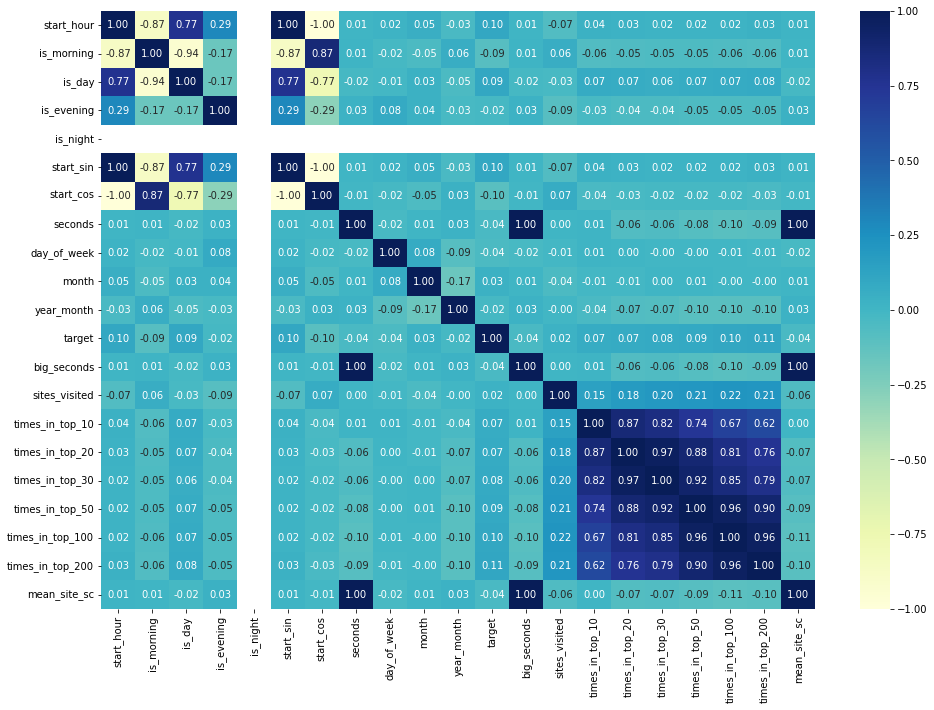

In [950]:
corr = feats_train.corr('spearman') 
plt.figure(figsize = ( 16 , 11 )) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

In [951]:
feats_train['start_hour']

session_id
21669     0.333333
54843     0.333333
77292     0.333333
114021    0.333333
146670    0.333333
            ...   
12224     0.958333
164438    0.958333
12221     0.958333
156968    0.958333
204762    0.958333
Name: start_hour, Length: 253561, dtype: float64

In [952]:
feats_train['is_night']

session_id
21669     0
54843     0
77292     0
114021    0
146670    0
         ..
12224     0
164438    0
12221     0
156968    0
204762    0
Name: is_night, Length: 253561, dtype: int64

,start_hour,is_morning,is_day,is_evening,is_night,day_of_week,month,year_month,sites_visited,mean_site,times_in_top_10,times_in_top_20,times_in_top_30,times_in_top_50,times_in_top_100,times_in_top_200
session_id,,,,,,,,,,,,,,,,
21669,0.333333,1,0,0,1,5,1,2.01301,2,0.000000,0,0,0,0,0,0
54843,0.333333,1,0,0,1,5,1,2.01301,4,446.500000,0,0,0,0,0,0
77292,0.333333,1,0,0,1,5,1,2.01301,10,0.400000,0,0,0,0,0,0
114021,0.333333,1,0,0,1,5,1,2.01301,10,0.300000,0,0,0,0,0,0
146670,0.333333,1,0,0,1,5,1,2.01301,10,0.200000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,0.958333,0,0,1,1,2,4,2.01404,10,1.200000,0,0,1,1,1,1
164438,0.958333,0,0,1,1,2,4,2.01404,10,17.800000,0,0,1,2,2,2
12221,0.958333,0,0,1,1,2,4,2.01404,10,2.800000,0,0,1,1,1,1


In [882]:
curr_feats_train.columns

Index(['start_hour', 'is_morning', 'is_day', 'is_evening', 'is_night',
       'start_sin', 'start_cos', 'seconds', 'day_of_week', 'month',
       'year_month', 'seconds', 'sites_visited', 'mean_site',
       'times_in_top_10', 'times_in_top_20', 'times_in_top_30',
       'times_in_top_50', 'times_in_top_100', 'times_in_top_200'],
      dtype='object')

In [ ]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10',\
                 'start_hour', 'year_month']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)


cv_scores10 = train_and_predict(model=logit, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

In [989]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10',\
                 'start_hour', 'year_month']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)

### Make big prediction

In [990]:
train_final = hstack([train, curr_feats_train])
test_final = hstack([test, curr_feats_test])

In [991]:
c_values = np.logspace(-2, 2, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=4, cv=time_split, verbose=1)

In [992]:
logit_grid_searcher.fit(train_final, y); 

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [993]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9232491455468225, {'C': 2.06913808111479})

In [994]:
final_model = logit_grid_searcher.best_estimator_

In [995]:
drop_features = ['min', 'max', 'start_cos', 'start_sin', 'big_seconds', 'times_in_top_10',\
                 'start_hour', 'year_month']
curr_feats_train = feats_train.copy().drop(drop_features + ['target'], axis=1)
curr_feats_test = feats_test.copy().drop(drop_features, axis=1)

cv_scores6 = train_and_predict(model=final_model, X_train=train, y_train=y,\
                               new_feature_names=[curr_feats_train, curr_feats_test],\
                               
                               X_test=test, site_feature_names=tf_idf.get_feature_names(),              
                               cv=time_split, submission_file_name='subm1.csv')

CV scores [0.85481653 0.93312129 0.88244228 0.98002692 0.86896111 0.97909711
 0.92442829 0.96902207 0.86420193 0.97637392]
CV mean: 0.9232491455468225, CV std: 0.049133441629273925


Weight?,Feature
+8.017,www.express.co.uk
+6.551,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.645,vk.com
+5.193,tru.am
+4.675,www.rhonealpesjob.com
+4.495,www.banque-chalus.fr
+4.376,youwatch.org
+4.290,mcetv.fr
+4.237,s.radio-canada.ca
+4.201,fr.glee.wikia.com


New feature weights:
             feature      coef
0         is_morning -2.884627
1             is_day  0.851631
2         is_evening -3.141229
3           is_night  0.000000
4            seconds -0.392208
5      sites_visited -0.160459
6    times_in_top_20 -0.796247
7    times_in_top_30  0.692034
8    times_in_top_50 -0.204210
9   times_in_top_100 -0.349813
10  times_in_top_200  0.825686
11      mean_site_sc  0.149880
12     day_of_week_0  1.210011
13     day_of_week_1  0.216303
14     day_of_week_2 -2.675820
15     day_of_week_3 -1.460134
16     day_of_week_4 -0.265939
17     day_of_week_5  0.683387
18     day_of_week_6 -2.882032
19           month_1 -1.838547
20           month_2 -0.265746
21           month_3 -0.709485
22           month_4 -0.092340
23           month_5 -1.183865
24           month_6 -0.957405
25           month_7 -0.069504
26           month_8 -1.248065
27           month_9  3.760191
28          month_10 -3.039675
29          month_11  0.484032
30          month_

ValueError: X has 50027 features, but LogisticRegression is expecting 50031 features as input.

In [997]:
feats_test.shape

(82797, 35)

In [998]:
feats_train.shape

(253561, 40)

In [999]:
set(curr_feats_train) - set(curr_feats_test)

{'month_1', 'month_2', 'month_3', 'month_4'}